<div>
<img src='https://www.sharif.edu/documents/20124/0/logo-fa-IR.png' alt="SUT logo" width=130 height=130 align=left class="saturate">

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<!-- <font color=0F5298 size=7> -->
<font color=0F5298 size=6>
    Deep Generative Models <br> <br>
<!-- <font color=2565AE size=5> -->
<font size=5>
    Computer Engineering Department <br>
    Spring 2024 <br> <br>
<font color=606060 size=5>
    Homework 3: Practical - VAE + Normalizing Flows <br> <br>
<font color=686880 size=4>
    TAs: Javad Razi (<a href="mailto:j.razi@outlook.com">j.razi@outlook.com</a>)

___

### Full Name : Amir Mohammad Babaei
### Student Number : 402212399
___

## Overview

Flow-based models represent a fascinating class of deep generative models that are uniquely positioned to model complex distributions. Unlike other generative approaches, flow-based models have the distinctive ability to perform exact likelihood evaluation and efficient, exact sampling. This capability stems from their fundamental design, which uses invertible transformations to map data to a latent space with a simpler, typically Gaussian, distribution. This mapping is both invertible and differentiable, ensuring that the transformations can smoothly handle complex, high-dimensional data distributions.

In this assignment, we aim to explore the limitations of Variational Autoencoders (VAEs) when tasked with generating realistic images from the CelebA dataset. We'll demonstrate how the inherent limitations of standard VAEs affect their ability to model this complex data, resulting in suboptimal image generation. To address these challenges, we'll then leverage normalizing flows to enhance the generative capacity of VAEs. By incorporating flows, we'll provide the model with a more flexible and expressive posterior distribution, enabling better representation of the intricate facial features present in CelebA. This approach will not only offer insights into flow-based models but also highlight their potential in tackling real-world image synthesis tasks.

# **Part I: Train and Evaluation of A Base VAE Model (30 pts)**

In this assignment, we're exploring the challenges and opportunities that arise when training a Variational Autoencoder (VAE) to generate high-quality images from the CelebA dataset. CelebA's inherent complexity demands a flexible, expressive generative model capable of handling the high variability of facial attributes. Standard VAEs often fall short due to their Gaussian posterior assumptions. To overcome this, we leverage the power of normalizing flows for more flexible posterior approximation and enhanced latent space representation.

The following questions will guide your understanding and analysis.

1. **Posterior Approximation and Generative Quality:**
   - In a standard VAE, the approximate posterior is modeled using a Gaussian distribution. How does this assumption impact the quality of image generation, and why might this approximation be particularly limiting for a dataset like CelebA? How do normalizing flows provide a more flexible posterior approximation, and how does this affect the generation process?

2. **Training Objectives and Regularization:**
   - Compare the effects of different beta values in the VAE objective function on the trade-off between reconstruction and regularization (KL divergence). How does the introduction of normalizing flows influence this trade-off, and what implications does it have for the capacity of the latent representation?

3. **Invertibility and Expressiveness:**
   - The transformation functions in normalizing flows must be both invertible and differentiable. Explain how these constraints affect the expressiveness of normalizing flows, particularly in capturing the complex, multimodal data distribution of CelebA. Why is maintaining these properties critical for efficient sampling and exact likelihood estimation?

4. **Latent Space Structure and Disentanglement:**
   - Describe how a well-structured latent space affects the quality of image generation and interpretability. How do normalizing flows influence the structure of the latent space compared to standard VAEs, and what challenges or benefits arise when attempting to disentangle features in the CelebA dataset?

5. **Likelihood Evaluation and Density Estimation:**
   - One of the primary advantages of normalizing flows is their ability to provide exact likelihood evaluation. Discuss why this property is significant for density estimation in deep generative models. What benefits does it offer for model evaluation compared to variational inference, and how does it align with maximum likelihood objectives?


<font size="4.5" color="alert">**Please provide detailed answer to these questions. Having a good grasp on the topics these questions cover is essential for this assignment**</font>


#### 1. Posterior Approximation and Generative Quality
In a standard Variational Autoencoder (VAE), the approximate posterior is typically modeled as a Gaussian distribution, which can limit the model's ability to generate complex images. This is particularly true for the CelebA dataset, which contains diverse and intricate facial features. A Gaussian posterior implies that the latent space follows a simple, unimodal distribution, which may not effectively capture the complexities and multimodal nature of real-world data like human faces.

Normalizing flows enhance this by providing a mechanism to transform a simple Gaussian distribution into a more complex one that better fits the data's actual distribution. This is achieved through a series of invertible and differentiable transformations, allowing the VAE to model more flexible and expressive posterior distributions. Consequently, the image generation process benefits from being able to capture finer details and variations, leading to higher quality and more realistic outputs.

#### 2. Training Objectives and Regularization
Standard VAEs use a beta parameter in the loss function to balance the trade-off between reconstruction fidelity and the regularization (measured by KL divergence). Increasing beta places more emphasis on the latent space's regularity at the expense of reconstruction accuracy, which can lead to more generalized but less precise outputs.

Introducing normalizing flows into VAEs alters this dynamic by enriching the expressiveness of the latent space. As a result, even with strong regularization, the model can still achieve detailed reconstructions. This means that the model can potentially maintain high-quality reconstructions while still enforcing a structured, useful latent representation, thus enhancing the overall capacity of the latent space to capture meaningful data variations.

#### 3. Invertibility and Expressiveness
Normalizing flows require the transformation functions to be both invertible and differentiable to ensure that the model can perform exact likelihood calculations and efficient, exact sampling. These constraints are crucial as they guarantee that every transformation in the flow is reversible, allowing an unambiguous mapping between the data and latent spaces. This ability is critical in modeling complex distributions such as those in the CelebA dataset, which are multimodal and highly varied. The requirement for differentiability ensures that these transformations can be optimized using gradient-based methods, central to training deep learning models effectively.

#### 4. Latent Space Structure and Disentanglement
A well-structured latent space significantly enhances the interpretability and quality of generated images. It ensures that different dimensions in the latent space correspond to meaningful variations in the output space, facilitating better control and understanding of the generative process. Normalizing flows can potentially improve the structuring of the latent space by allowing more complex transformations, thus enabling better disentanglement of features. However, the challenge lies in designing flow architectures that provide the desired level of disentanglement without overly complicating the model or the training process.

#### 5. Likelihood Evaluation and Density Estimation
One of the significant advantages of normalizing flows is their ability to perform exact likelihood evaluations. This capability is crucial for effective density estimation, as it allows the model to directly calculate the probability of the data under the model distribution. This exactness is particularly beneficial in settings where precise probabilistic outputs are necessary, such as in anomaly detection or model comparison. Furthermore, exact likelihood evaluation aligns well with the maximum likelihood objectives, providing a clear optimization target and potentially leading to more stable and interpretable model training outcomes.

## Initial Setup

In [ ]:
%pip install seaborn

In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
from os.path import join as oj

## Preparing The Data

We are using the CelebA dataset for this assignment, known for its rich diversity of facial attributes across over 200,000 celebrity images. This dataset provides a comprehensive challenge for evaluating generative models due to its high variability in facial features, expressions, and poses.

### Transformations
- **Resizing:** All images are resized to 64x64 pixels for uniform input shape and to simplify computational requirements.
- **Normalization:** Normalized to a range of -1 to 1 for better training stability.

The code below handles these transformations and prepares the dataset for efficient training.


In [2]:
!gdown 1Tu4SWr9HdN6yWq8e7yAaNzCZoVoLEqpP

Downloading...
From (original): https://drive.google.com/uc?id=1Tu4SWr9HdN6yWq8e7yAaNzCZoVoLEqpP
From (redirected): https://drive.google.com/uc?id=1Tu4SWr9HdN6yWq8e7yAaNzCZoVoLEqpP&confirm=t&uuid=57571885-9453-4126-af02-dc4240684040
To: /content/celeba.zip
100% 1.43G/1.43G [00:11<00:00, 125MB/s]


In [ ]:
%cd ..
!unzip content/celeba.zip
%cd content

In [4]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

BATCH_SIZE = 64

root_path = './data'

train_loader = torch.utils.data.DataLoader(
    datasets.CelebA(root=root_path, split='train', target_type='attr', transform=transform, download=False),
    batch_size=BATCH_SIZE, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    datasets.CelebA(root=root_path, split='valid', target_type='attr', transform=transform, download=False),
    batch_size=BATCH_SIZE, shuffle=False)

test_loader = torch.utils.data.DataLoader(
    datasets.CelebA(root=root_path, split='test', target_type='attr', transform=transform, download=False),
    batch_size=BATCH_SIZE, shuffle=False)


## Base VAE Model

In this assignment, we've implemented a modular Variational Autoencoder (VAE) architecture tailored to the CelebA dataset. The base VAE leverages convolutional and transposed convolutional layers to effectively downsample and upsample the input images, respectively. This architecture is carefully designed to capture the complex attributes of facial images while remaining computationally efficient.

### Overview of the Architecture
- **Encoder and Decoder Structure:** The encoder compresses images into a compact latent representation, while the decoder reconstructs the images using symmetric, yet effective, layers. The model captures a broad range of facial attributes due to its layered structure and dimensionality of the latent space.
  
- **Latent Space Exploration:** An appropriate choice for latent dimension allows the model to capture intricate variations present in CelebA, enabling exploration of this space for image generation and manipulation.

- **Reparameterization Trick:** To ensure gradient propagation through the stochastic sampling process, the reparameterization trick maps the latent Gaussian distribution for more stable and effective training.

### Modularity and Flexibility
The modular structure of the `VAE` class allows straightforward customization. By encapsulating the encoder and decoder as separate modules, this class will easily integrate alternative transformations, such as normalizing flows, in subsequent sections. Additionally, feel free to modify the architecture of the model if you deem fit. But provide a reasonable justification on why you altered certain parts.


In [ ]:
import torch
from torch import nn

class Encoder(nn.Module):
    def __init__(self, in_channels, base_filters, latent_dim):
        super(Encoder, self).__init__()
        self.base_filters = base_filters
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, base_filters, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(base_filters, base_filters * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(base_filters * 2, base_filters * 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(base_filters * 4, base_filters * 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(base_filters * 8 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(base_filters * 8 * 4 * 4, latent_dim)

    def forward(self, x):
        h = self.conv_layers(x)
        h = h.view(h.size(0), -1)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, out_channels, base_filters, latent_dim):
        super(Decoder, self).__init__()
        self.fc_decode = nn.Linear(latent_dim, base_filters * 8 * 4 * 4)
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(base_filters * 8, base_filters * 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(base_filters * 4, base_filters * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(base_filters * 2, base_filters, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(base_filters, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        h = self.fc_decode(z)
        h = h.view(h.size(0), self.deconv_layers[0].in_channels, 4, 4)
        return self.deconv_layers(h)

class VAE(nn.Module):
    def __init__(self, in_channels=3, base_filters=32, latent_dim=128):
        super(VAE, self).__init__()
        self.encoder = Encoder(in_channels, base_filters, latent_dim)
        self.decoder = Decoder(in_channels, base_filters, latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar, recon_loss_fn=nn.functional.mse_loss, beta=1.0):
    recon_loss = recon_loss_fn(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kld_loss


### Optimizer and Learning Rate Scheduler

Efficient training requires careful selection of optimization and scheduling strategies. Here, you must choose the appropriate optimizer and learning rate scheduler from several supported options:

- **Optimizers:** Choose between `Adam` or `SGD` based on the model's complexity and training dynamics. Adam offers adaptive learning rates that typically result in faster convergence, while SGD provides more controlled updates with momentum, which may help when tuning the model manually.

- **Schedulers:** Select a learning rate scheduler to dynamically adjust the learning rate:
  - **StepLR:** Periodically reduces the learning rate by a set factor, useful for models that gradually settle into a minimum.
  - **ReduceLROnPlateau:** Monitors validation metrics and adjusts learning rates only when progress stalls, offering more nuanced learning adjustments.

### Justification
Selecting an appropriate optimizer and scheduler combination is crucial for ensuring stable and efficient training. The flexibility to adapt training strategies enables tackling various challenges, such as overfitting, convergence issues, and learning plateaus.


In [6]:
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

def create_optimizer_scheduler(model, optimizer_name='adam', learning_rate=1e-3, scheduler_name='steplr', step_size=10, gamma=0.1):
    if optimizer_name.lower() == 'adam':
        optimizer = Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name.lower() == 'sgd':
        optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    if scheduler_name.lower() == 'steplr':
        scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_name.lower() == 'reducelronplateau':
        scheduler = ReduceLROnPlateau(optimizer, factor=gamma, patience=step_size)
    else:
        raise ValueError(f"Unsupported scheduler: {scheduler_name}")

    return optimizer, scheduler

In [7]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


### Training Logs

In [8]:
import json

class TrainingLogger:
    def __init__(self):
        self.logs = {'train_loss': [], 'val_loss': []}

    def add_epoch_loss(self, train_loss, val_loss):
        self.logs['train_loss'].append(train_loss)
        self.logs['val_loss'].append(val_loss)

    def save(self, file_path='training_logs.json'):
        with open(file_path, 'w') as f:
            json.dump(self.logs, f)


## Training the Model

In [9]:
def train_vae(model, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping, logger, device='cpu'):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(data)
            loss = vae_loss(recon, data, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                recon, mu, logvar = model(data)
                val_loss += vae_loss(recon, data, mu, logvar).item()

        val_loss /= len(val_loader.dataset)

        scheduler.step(val_loss if isinstance(scheduler, ReduceLROnPlateau) else epoch)

        logger.add_epoch_loss(train_loss, val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if early_stopping(val_loss):
            print("Early stopping triggered")
            break

    logger.save()



**Complete below code to train the VAE model.**

In [11]:
# Initialize computing device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the VAE model
vae = VAE(in_channels=3, base_filters=32, latent_dim=64).to(device)

# Setup optimizer and scheduler
optimizer, scheduler = create_optimizer_scheduler(vae, optimizer_name='adam', scheduler_name='steplr', learning_rate=1e-3)

# Early stopping mechanism (to be implemented)
early_stopping = EarlyStopping(patience=5, min_delta=0.01)  # TODO

# Logger for training metrics (to be implemented)
logger = TrainingLogger()  # TODO

# Train the VAE model
### TODO ###
train_vae(vae, train_loader, val_loader, optimizer, scheduler, num_epochs=20, early_stopping=early_stopping, logger=logger, device=device)

Epoch 1/20, Train Loss: 740.1664, Val Loss: 561.8000
Epoch 2/20, Train Loss: 543.0546, Val Loss: 588.2632
Epoch 3/20, Train Loss: 524.4451, Val Loss: 523.1344
Epoch 4/20, Train Loss: 512.8169, Val Loss: 510.1039
Epoch 5/20, Train Loss: 505.9142, Val Loss: 510.7553
Epoch 6/20, Train Loss: 501.3059, Val Loss: 501.3641
Epoch 7/20, Train Loss: 497.8947, Val Loss: 511.3866
Epoch 8/20, Train Loss: 494.9949, Val Loss: 501.1768
Epoch 9/20, Train Loss: 492.9202, Val Loss: 508.6211
Epoch 10/20, Train Loss: 491.0071, Val Loss: 494.6959
Epoch 11/20, Train Loss: 489.5035, Val Loss: 498.0957
Epoch 12/20, Train Loss: 473.7562, Val Loss: 477.9300
Epoch 13/20, Train Loss: 471.7455, Val Loss: 477.1669
Epoch 14/20, Train Loss: 470.8685, Val Loss: 476.6162
Epoch 15/20, Train Loss: 470.2703, Val Loss: 476.9709
Epoch 16/20, Train Loss: 469.8133, Val Loss: 476.1823
Epoch 17/20, Train Loss: 469.4129, Val Loss: 475.9755
Epoch 18/20, Train Loss: 469.0375, Val Loss: 475.8753
Epoch 19/20, Train Loss: 468.6861, Va

## Evaluation of Base VAE

In [12]:
import pandas as pd

# Convert logs to a DataFrame for easy viewing
logs_df = pd.DataFrame({'Epoch': range(1, len(logger.logs['train_loss']) + 1),
                        'Train Loss': logger.logs['train_loss'],
                        'Validation Loss': logger.logs['val_loss']})

# Save logs to a file
logger.save('celeba_training_logs.json')

display(logs_df)

,Epoch,Train Loss,Validation Loss
0,1,740.166392,561.799954
1,2,543.054617,588.263170
2,3,524.445054,523.134413
3,4,512.816942,510.103929
4,5,505.914193,510.755300
5,6,501.305859,501.364145
6,7,497.894730,511.386575
7,8,494.994945,501.176760
8,9,492.920181,508.621106
9,10,491.007052,494.695918


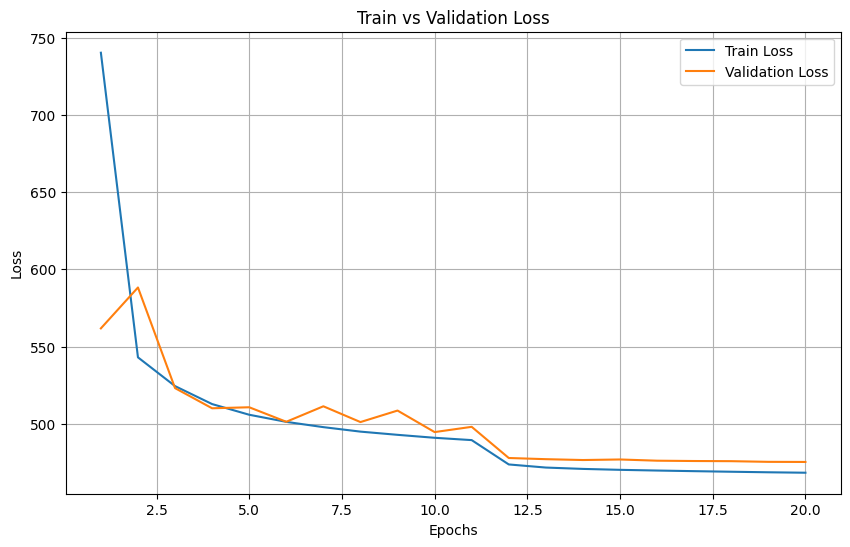

In [13]:
import matplotlib.pyplot as plt

def plot_loss(logger):
  plt.figure(figsize=(10, 6))
  plt.plot(range(1, len(logger.logs['train_loss']) + 1), logger.logs['train_loss'], label='Train Loss')
  plt.plot(range(1, len(logger.logs['val_loss']) + 1), logger.logs['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Train vs Validation Loss')
  plt.legend()
  plt.grid(True)
  plt.show()



plot_loss(logger)

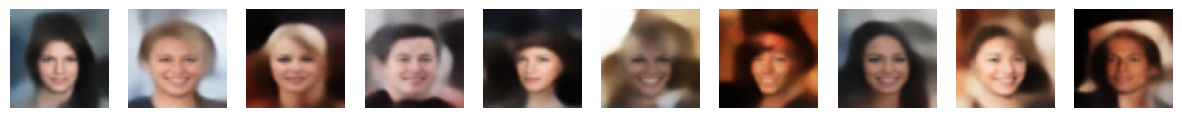

In [14]:
# Generate some images from the trained model (VAE)
vae.eval()
num_samples = 10
latent_dim = vae.encoder.fc_mu.out_features

# Sample random latent vectors
with torch.no_grad():
    z = torch.randn(num_samples, latent_dim).to(device)
    generated_images = vae.decoder(z).cpu()

fig, axs = plt.subplots(1, num_samples, figsize=(15, 15))
for i in range(num_samples):
    axs[i].imshow(generated_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Denormalize and transpose
    axs[i].axis('off')
plt.show()


### Advanced Evaluation Metrics for VAE

In this section, you'll enhance your VAE evaluation by implementing advanced metrics for image generation. These metrics offer deeper insights into the quality and diversity of your generated samples:

- **Reconstruction Error**: Quantifies how accurately the model reconstructs input images. Common measures include Mean Squared Error (MSE) and Binary Cross-Entropy (BCE).

- **KL Divergence**: Assesses how well the learned latent distribution aligns with the Gaussian prior, encouraging efficient encoding.

- **Inception Score (IS)**: Evaluates the quality and diversity of generated images using a pretrained classifier.

- **Frechet Inception Distance (FID)**: Compares the statistical similarity between generated images and real data distributions.

**Instructions**:
1. Implement modular, reusable functions for each metric to streamline analysis:
    - Calculate reconstruction error and KL Divergence per batch.
    - Use a pretrained Inception model to compute IS and FID scores.

**Examples**:
```python
def calculate_reconstruction_error(original, reconstructed, loss_fn):
    """Compute reconstruction error between original and generated images."""
    return loss_fn(reconstructed, original).item()

def calculate_kl_divergence(mu, logvar):
    """Compute KL Divergence across a batch."""
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).item()
```

In [15]:
import numpy as np
from scipy.linalg import sqrtm
from torchvision.models import inception_v3


######## TODO ########
### Your Code Here ###
######################
def calculate_reconstruction_error(original, reconstructed, loss_fn=nn.functional.mse_loss):
    """
    Compute reconstruction error between original and generated images.
    Parameters:
        original (Tensor): The original images.
        reconstructed (Tensor): The reconstructed images generated by the VAE.
        loss_fn (function): Loss function to calculate the error.
    Returns:
        float: The reconstruction error for the batch.
    """
    return loss_fn(reconstructed, original, reduction='mean').item()


def calculate_kl_divergence(mu, logvar):
    """
    Compute KL Divergence for a batch to measure how well the latent variables
    and their distribution conform to the prior distribution.
    Parameters:
        mu (Tensor): Mean from the encoder's output.
        logvar (Tensor): Log variance from the encoder's output.
    Returns:
        float: The KL divergence for the batch.
    """
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).item()


def inception_score(imgs, inception_model, splits=1):
    """
    Calculate the Inception Score for generated images.
    Parameters:
        imgs (Tensor): Batch of generated images.
        inception_model (nn.Module): Pretrained Inception v3 model.
        splits (int): Number of splits for calculating mean and std.
    Returns:
        float: The Inception Score.
    """
    with torch.no_grad():
        preds = inception_model(imgs)
        preds = F.softmax(preds, dim=1)
        scores = []
        for i in range(splits):
            part = preds[i * (preds.shape[0] // splits):(i + 1) * (preds.shape[0] // splits), :]
            kl = part * (torch.log(part) - torch.log(torch.mean(part, dim=0)))
            kl = kl.sum(dim=1)
            scores.append(torch.exp(kl.mean()).cpu().numpy())
        return float(np.mean(scores))


def calculate_fid(real_features, gen_features):
    """
    Calculate the Frechet Inception Distance between real and generated images.
    Parameters:
        real_features (ndarray): Feature vectors of real images.
        gen_features (ndarray): Feature vectors of generated images.
    Returns:
        float: The FID score.
    """
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = gen_features.mean(axis=0), np.cov(gen_features, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return np.trace(sigma1 + sigma2 - 2 * covmean)


# Function to extract features from the Inception model
def get_features_from_inception(images, inception_model):
    with torch.no_grad():
        return inception_model(images).detach().cpu().numpy()


# Load the pretrained Inception model
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.eval()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 177MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri



---



# **PART II: Improving VAE with Normalizing Flows (70 pts + 25 bonus pts )**

While VAEs offer a strong framework for generative modeling, their reliance on Gaussian latent variables often limits their expressiveness, particularly when working with complex datasets like CelebA. To address these shortcomings, we introduce normalizing flows to improve the VAE's ability to represent intricate data distributions.

### Overview and Intuition
Normalizing flows are a series of invertible transformations that map simple distributions to more complex ones. By stacking these transformations, a VAE with normalizing flows can learn a more flexible posterior distribution:
- **Enhanced Posterior Flexibility:** The flows refine the latent representation, enabling it to capture complex, multimodal features not possible with standard Gaussian assumptions.
- **Exact Likelihood Evaluation:** Each transformation maintains a bijective mapping, allowing for precise log-likelihood estimation.
- **Invertible Transformations:** Invertibility ensures efficient sampling and reconstruction, enhancing the quality of generated images.

### Integration with VAEs
By integrating normalizing flows into the VAE, we leverage the benefits of flexible posterior approximations while maintaining the core reparameterization structure. This approach provides a direct improvement over the base VAE, enabling it to generate sharper, more accurate images that align with CelebA's diverse facial features.

In the following sections, we'll discuss the implementation and training of a VAE with normalizing flows, demonstrating how this powerful combination can significantly enhance the model's generative capabilities.




---



## An In-Depth Understanding of Flow-Based Models

Flow-based models offer an exciting and versatile approach to deep generative modeling, providing exact likelihood estimation while maintaining efficient sampling capabilities. These models, relying on invertible transformations, are gaining recognition as valuable tools for understanding complex data distributions. To help you gain a deeper understanding of this paradigm, consider these two insightful resources.

### 1. Article: *Flow-based Deep Generative Models* by Lilian Weng

Lilian Weng's article is an excellent starting point for grasping the foundations and recent developments of flow-based models. It provides a well-structured overview of various types and architectures, along with their mathematical underpinnings:
- **Change of Variable Theorem:** Fundamental in normalizing flows, this theorem provides the mathematical basis for density transformations.
- **Models with Normalizing Flows:** This section covers popular architectures like RealNVP, NICE, and Glow.
- **Models with Autoregressive Flows:** Explores the likes of MADE, PixelRNN, and WaveNet.
- **VAE + Flows:** Discusses how VAEs can be enhanced with flow-based approaches.

This article is thorough yet digestible, guiding readers through the nuances of flow models and offering practical implementations.
[Read the full article here](https://lilianweng.github.io/posts/2018-10-13-flow-models/)

### 2. Lecture Video: *Flow Models* by Peter Abbeel

This lecture is an insightful, awesome resource for understanding the principles and challenges of flow-based models:
- **Key Features of Generative Models:** Discusses crucial criteria like latent representation and accurate sampling.
- **Foundational Principles:** Explores invertible transformations, mapping data to spaces with tractable distributions, and the Change of Variables formula.
- **Challenges and Flexibility:** Examines the challenges of maintaining invertibility and compares flow models to VAEs for specific tasks.

This lecture provides a comprehensive yet concise explanation of the theoretical foundations and practical challenges of these models.
[Watch the lecture here](https://www.youtube.com/watch?v=SkSDCzz41Vs)



---



### Objectives

1. **Integrate Normalizing Flows**: Implement normalizing flows to refine the latent posterior of the VAE.
2. **Evaluate Performance**: Assess the model using reconstruction error, KL divergence, Inception Score, and Frechet Inception Distance.
3. **Compare to Base VAE**: Benchmark the f-VAE's performance against the baseline VAE.

### Implementation Steps
1. **Define Flow Components**:
   - Implement invertible transformations using simple affine functions or autoregressive models.
   - Chain multiple flows together to increase expressiveness.
   - Ensure that each transformation is invertible for precise likelihood estimation.

```python
# TODO: Define a class for a simple flow component (e.g., Planar, Radial, etc.)
class PlanarFlow(nn.Module):
    def __init__(self, input_dim):
        # TODO: Initialize flow parameters
        pass

    def forward(self, x):
        # TODO: Apply forward transformation
        pass

    def inverse(self, x):
        # TODO: Apply inverse transformation
        pass
```

2. **Build a Stacked Flow Network**:
    - Create a series of flow layers that apply transformations in sequence.
    - Ensure each flow has unique parameters.
    - Pass the latent space representation through the flow network to refine it.


```python
# TODO: Implement a class that stacks multiple flow components together
class NormalizingFlow(nn.Module):
    def __init__(self, num_flows, input_dim):
        # TODO: Initialize multiple flow components
        pass

    def forward(self, x):
        # TODO: Apply transformations sequentially
        pass

    def inverse(self, x):
        # TODO: Apply inverse transformations sequentially
        pass
```

3. **Integrate with VAE**:
   - Modify the VAE architecture to incorporate the flow network.
   - Refine the posterior distribution by passing it through the flow network.
   - **Models to Consider:**
     1. **Planar Flow:** Planar Flow applies a simple, single-layer transformation using a linear layer combined with a hyperbolic tangent activation function. It is computationally efficient and straightforward to implement, providing a basic yet effective way to add non-linearity to the posterior distribution. Although limited in expressiveness compared to other flows, it can be an effective initial approach for enhancing VAEs.

     2. **RealNVP:** Real-valued Non-Volume Preserving (RealNVP) transformations use affine coupling layers that divide data into subsets. By keeping one subset fixed and transforming the other with a learned function, RealNVP achieves efficient density estimation.

     3. **Glow:** Glow is a reversible architecture that stacks multiple invertible 1x1 convolutions, offering flexibility in channel-wise transformations.

     4. **MADE/MAF:** Masked Autoencoder Density Estimation (MADE) and Masked Autoregressive Flow (MAF) leverage autoregressive properties to model complex data distributions.

```python

# TODO: Modify the VAE class to include normalizing flows
class VAEWithFlows(nn.Module):
    def __init__(self, in_channels=3, base_filters=32, latent_dim=64, num_flows=4):
        super(VAEWithFlows, self).__init__()
        # TODO: Initialize the base VAE components (encoder, decoder)
        # TODO: Add normalizing flow components
        pass

    def forward(self, x):
        # TODO: Pass through the encoder and refine with normalizing flows
        pass

    def reparameterize(self, mu, logvar):
        # TODO: Sample latent variables and pass through the flow network
        pass

```

4. **Train and Evaluate**:
    - Train the f-VAE using similar metrics as the base VAE.
    - Compare results with reconstruction loss, KL divergence, IS, and FID.


```python
# TODO: Train the f-VAE model and compare metrics with the base VAE
# - Reconstruction Error
# - KL Divergence
# - Inception Score
# - Frechet Inception Distance
```

5. **Expected Outcomes and Evaluation Criteria**:
   - **Model Choice Justification:** Choosing a sensible model and providing a solid justification for your choice will be a significant factor in the grade. Up to 25 bonus points will be awarded based on how well the model is integrated with the VAE and its performance.
   - Implementing flows correctly and efficiently.
   - Correct computation of quantitative metrics such as FID (Frechet Inception Distance) or log-likelihood to assess model performance.



**Good luck!** This assignment is designed to provide you with practical experience in implementing and enhancing VAEs using normalizing flows. You are encouraged to experiment and adapt the notebook, choosing your own models and implementation strategies, provided they are logically sound. Writing decent explanations for the decisions you make in your implementation is crucial in conveying your understanding and approach. Make sure each choice is clearly justified and related to the overall learning objectives of the assignment.


In [18]:
#################
##### TODO ######
#################
import torch
import torch.nn as nn
from torch import Tensor
from typing import Tuple


class PlanarFlow(nn.Module):
    """Implementation of the invertible transformation used in planar flow:
        f(z) = z + u * h(dot(w.T, z) + b)
    See Section 4.1 in https://arxiv.org/pdf/1505.05770.pdf.
    """

    def __init__(self, dim: int = 2):
        """Initialise weights and bias.

        Args:
            dim: Dimensionality of the distribution to be estimated.
        """
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, dim).normal_(0, 0.1))
        self.b = nn.Parameter(torch.randn(1).normal_(0, 0.1))
        self.u = nn.Parameter(torch.randn(1, dim).normal_(0, 0.1))

    def forward(self, z: Tensor) -> Tensor:
        if torch.mm(self.u, self.w.T) < -1:
            self.get_u_hat()

        return z + self.u * nn.Tanh()(torch.mm(z, self.w.T) + self.b)

    def log_det_J(self, z: Tensor) -> Tensor:
        if torch.mm(self.u, self.w.T) < -1:
            self.get_u_hat()
        a = torch.mm(z, self.w.T) + self.b
        psi = (1 - nn.Tanh()(a) ** 2) * self.w
        abs_det = (1 + torch.mm(self.u, psi.T)).abs()
        log_det = torch.log(1e-4 + abs_det)

        return log_det

    def get_u_hat(self) -> None:
        """Enforce w^T u >= -1. When using h(.) = tanh(.), this is a sufficient condition
        for invertibility of the transformation f(z). See Appendix A.1.
        """
        wtu = torch.mm(self.u, self.w.T)
        m_wtu = -1 + torch.log(1 + torch.exp(wtu))
        self.u.data = (
            self.u + (m_wtu - wtu) * self.w / torch.norm(self.w, p=2, dim=1) ** 2
        )


class NormalizingFlow(nn.Module):
    def __init__(self, dim: int = 2, K: int = 6):
        """Make a planar flow by stacking planar transformations in sequence.

        Args:
            dim: Dimensionality of the distribution to be estimated.
            K: Number of transformations in the flow.
        """
        super().__init__()
        self.layers = [PlanarFlow(dim) for _ in range(K)]
        self.model = nn.Sequential(*self.layers)

    def forward(self, z: Tensor) -> Tuple[Tensor, float]:
        log_det_J = 0

        for layer in self.layers:
            log_det_J += layer.log_det_J(z)
            z = layer(z)

        return z, log_det_J


class VAEWithFlows(nn.Module):
    def __init__(self, in_channels=3, base_filters=32, latent_dim=64, num_flows=4):
        super(VAEWithFlows, self).__init__()
        self.encoder = Encoder(in_channels, base_filters, latent_dim)
        self.decoder = Decoder(in_channels, base_filters, latent_dim)
        self.flow = NormalizingFlow(latent_dim, num_flows)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        z, log_det_jacobian = self.flow(z)
        return z, log_det_jacobian

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z, log_det_jacobian = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar, log_det_jacobian


def vae_loss_with_flows(recon_x, x, mu, logvar, log_det_jacobian, recon_loss_fn=nn.functional.mse_loss, beta=1.0):
    recon_loss = recon_loss_fn(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    flow_loss = -torch.sum(log_det_jacobian)
    return recon_loss + beta * (kld_loss + flow_loss)

def train_vae_with_flows(model, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping, logger, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            recon, mu, logvar, log_det_jacobian = model(data)
            loss = vae_loss_with_flows(recon, data, mu, logvar, log_det_jacobian)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                recon, mu, logvar, log_det_jacobian = model(data)
                val_loss += vae_loss_with_flows(recon, data, mu, logvar, log_det_jacobian).item()

        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss if isinstance(scheduler, ReduceLROnPlateau) else epoch)
        logger.add_epoch_loss(train_loss, val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if early_stopping(val_loss):
            print("Early stopping triggered")
            break

    logger.save()

# Instantiate the VAE model with flows
vae_with_flows = VAEWithFlows(in_channels=3, base_filters=32, latent_dim=64, num_flows=4).to(device)

# Setup optimizer and scheduler
optimizer, scheduler = create_optimizer_scheduler(vae_with_flows, optimizer_name='adam', scheduler_name='steplr', learning_rate=1e-3)

# Train the VAE model with flows
train_vae_with_flows(vae_with_flows, train_loader, val_loader, optimizer, scheduler, num_epochs=20, early_stopping=early_stopping, logger=logger, device=device)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/20, Train Loss: 745.0676, Val Loss: 562.4320
Epoch 2/20, Train Loss: 542.1111, Val Loss: 528.7687
Epoch 3/20, Train Loss: 524.3248, Val Loss: 519.6124
Epoch 4/20, Train Loss: 512.4713, Val Loss: 509.1320
Epoch 5/20, Train Loss: 504.2041, Val Loss: 503.1605
Epoch 6/20, Train Loss: 498.7047, Val Loss: 501.8850
Epoch 7/20, Train Loss: 494.9429, Val Loss: 503.0182
Epoch 8/20, Train Loss: 492.0481, Val Loss: 498.6128
Epoch 9/20, Train Loss: 489.5017, Val Loss: 494.1942
Epoch 10/20, Train Loss: 487.5746, Val Loss: 493.8965
Epoch 11/20, Train Loss: 485.7875, Val Loss: 494.0277
Epoch 12/20, Train Loss: 469.4804, Val Loss: 473.4259
Epoch 13/20, Train Loss: 467.3850, Val Loss: 472.6870
Epoch 14/20, Train Loss: 466.4876, Val Loss: 472.3762
Epoch 15/20, Train Loss: 465.8044, Val Loss: 472.3239
Epoch 16/20, Train Loss: 465.3209, Val Loss: 472.0995
Epoch 17/20, Train Loss: 464.8608, Val Loss: 471.1242
Epoch 18/20, Train Loss: 464.4384, Val Loss: 471.0842
Epoch 19/20, Train Loss: 464.1486, Va

In [ ]:
# Function to perform evaluation
def evaluate_model(model, loader, inception_model):
    reconstruction_errors = []
    kld_values = []
    inception_scores = []
    real_features = []
    gen_features = []

    for imgs, _ in loader:
        imgs = imgs.to(device)
        with torch.no_grad():
            reconstructed_imgs, mu, logvar = model(imgs)
            real_features.extend(get_features_from_inception(imgs, inception_model))
            gen_features.extend(get_features_from_inception(reconstructed_imgs, inception_model))

        # Calculate metrics
        rec_error = calculate_reconstruction_error(imgs, reconstructed_imgs)
        kld = calculate_kl_divergence(mu, logvar)

        reconstruction_errors.append(rec_error)
        kld_values.append(kld)

    # Calculate Inception Score and FID
    inception_score_value = inception_score(torch.tensor(gen_features), inception_model, splits=10)
    fid_score = calculate_fid(np.array(real_features), np.array(gen_features))

    return {
        "Average Reconstruction Error": np.mean(reconstruction_errors),
        "Average KL Divergence": np.mean(kld_values),
        "Inception Score": inception_score_value,
        "FID Score": fid_score
    }

# Evaluate both models
vae_results = evaluate_model(vae, test_loader, inception_model)
vae_with_flows_results = evaluate_model(vae_with_flows, test_loader, inception_model)

# Print the results
print("VAE Results:", vae_results)
print("VAE with Flows Results:", vae_with_flows_results)



---



# Part III: f-VAEs (Bonus, 50 pts)

To further understand the potential of normalizing flows in VAEs, it's crucial to delve into the foundational paper "[f-VAEs: Improved VAEs with Conditional Flows](https://arxiv.org/abs/1809.05861)". The paper provides a comprehensive approach to integrating conditional normalizing flows within VAEs (resulting in f-VAEs), demonstrating how they improve the expressiveness of latent distributions.

### Implementation Instructions
You are encouraged to read the paper and understand its methodology. The key objective is to implement the paper's ideas for integrating normalizing flows into VAEs:
1. Develop a conditional normalizing flow within the VAE architecture.
2. Understand how conditional flows can refine the posterior approximation to capture rich data distributions.
3. Evaluate the model on same metrics and compare the performance of all three models.


<font color="alert" size="4.5">**Before starting the implementation, please answer the following questions.**</font>

### Questions
1. **Expressiveness of Posterior Distributions:** How does the addition of conditional flows in f-VAEs affect the complexity and diversity of the posterior distribution, and what practical impact does this have on the quality of generated images?

2. **Training Stability and Convergence:** Conditional flows introduce additional parameters and layers. What strategies can be used to ensure stable training of f-VAEs while achieving convergence, particularly in complex datasets?

3. **GAN-VAE Hybridization:** How can adversarial learning, through GANs, complement conditional flows in refining the latent representations for generating sharper and more realistic images?

### 1. Expressiveness of Posterior Distributions

**Impact of Conditional Flows in f-VAEs:**
The addition of conditional flows in f-VAEs significantly enhances the expressiveness and diversity of the posterior distributions. By conditioning the flows on the input data or latent variables, f-VAEs can adapt the transformation of the latent space dynamically, depending on the input. This results in a more flexible posterior that can model complex, multimodal distributions effectively.

**Practical Impact on Generated Images:**
This increased expressiveness directly impacts the quality of the generated images by allowing the model to capture nuanced details and variations specific to the data set. For instance, in datasets with high variability such as CelebA, conditional flows enable f-VAEs to generate more accurate and diverse facial features, improving the fidelity and realism of the synthesized images. The ability to model intricate distributions ensures that subtle features are preserved and accurately represented in the generated outputs.

### 2. Training Stability and Convergence

**Strategies for Stable Training of f-VAEs:**
- **Gradual Increase in Complexity:** Start with simpler flow architectures and gradually introduce more complex flows as training progresses. This staged approach helps in stabilizing the training dynamics early on.
- **Careful Initialization:** Implementing specific initialization strategies for flow parameters can reduce initial instabilities. Using methods like orthogonal or identity matrix initialization for weights can help maintain the stability of the transformations.
- **Robust Optimization Techniques:** Utilizing adaptive learning rate methods such as Adam or RMSprop can help in dealing with the complexities introduced by additional parameters and layers. These optimizers are effective in handling the varying gradients and scales of update steps.
- **Regularization:** Adding regularization techniques such as dropout or weight decay within the flow layers can prevent overfitting and help in achieving better convergence, especially on complex datasets.
- **Batch Normalization:** Employing batch normalization within flows can aid in stabilizing the training by normalizing the activations and gradients. This can be particularly useful when training on diverse and large datasets.

### 3. GAN-VAE Hybridization

**Integration with Adversarial Learning:**
Integrating Generative Adversarial Networks (GANs) with f-VAEs can significantly enhance the refinement of latent representations, aiding in the generation of sharper and more realistic images. Here’s how adversarial learning can complement conditional flows:

- **Adversarial Regularization:** Incorporating an adversarial loss (similar to that used in GANs) can encourage the decoder to generate images that are indistinguishable from real images, thus pushing the generated samples to be more realistic.
- **Latent Space Refinement:** Adversarial learning can be used to refine the output of the conditional flows in the latent space, ensuring that the distributions are aligned more closely with the real data distribution. This process can help in enhancing the sharpness and detail of the generated images.
- **Feedback Mechanism:** Using a discriminator as a critic provides direct feedback to the flow-based VAE on the quality of the generated images. This feedback loop helps in fine-tuning the latent representations and improving the overall image quality.
- **Improved Sampling:** GANs can improve the sampling process by guiding the selection of latent variables that are more likely to produce high-quality images, thus enhancing the effectiveness of the sampling mechanism in f-VAEs.

By leveraging the strengths of both conditional flows and adversarial learning, f-VAEs can achieve superior performance in terms of image quality, diversity, and realism. This hybrid approach marries the best of both worlds, utilizing the structured learning of VAEs with the robustness of adversarial training to produce compelling results in generative tasks.